In [1]:
!mkdir -p data/sberbank-russian-housing-market

In [2]:
!unzip -o data/sberbank-russian-housing-market.zip -d data/sberbank-russian-housing-market

Archive:  data/sberbank-russian-housing-market.zip
  inflating: data/sberbank-russian-housing-market/data_dictionary.txt  
  inflating: data/sberbank-russian-housing-market/macro.csv.zip  
  inflating: data/sberbank-russian-housing-market/sample_submission.csv.zip  
  inflating: data/sberbank-russian-housing-market/test.csv.zip  
  inflating: data/sberbank-russian-housing-market/train.csv.zip  


In [3]:
import zipfile
from statistics import mean

import advertion
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

seed = np.random.RandomState(31337)

In [4]:
z = zipfile.ZipFile("data/sberbank-russian-housing-market/train.csv.zip")
z.extractall("data/sberbank-russian-housing-market/")

t = zipfile.ZipFile("data/sberbank-russian-housing-market/test.csv.zip")
t.extractall("data/sberbank-russian-housing-market/")

In [5]:
trainset = pd.read_csv("data/sberbank-russian-housing-market/train.csv")

trainset.shape

(30471, 292)

In [6]:
testset = pd.read_csv("data/sberbank-russian-housing-market/test.csv")

testset.shape

(7662, 291)

In [7]:
trainset.columns

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc'],
      dtype='object', length=292)

In [8]:
trainset

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,30469,2015-06-30,44,27.0,7.0,9.0,1.0,1975.0,2.0,6.0,...,15,5,0,15,26,1,2,84,6,7400000
30467,30470,2015-06-30,86,59.0,3.0,9.0,2.0,1935.0,4.0,10.0,...,313,128,24,98,182,1,82,171,15,25000000
30468,30471,2015-06-30,45,NaN,10.0,20.0,1.0,NaN,1.0,1.0,...,1,1,0,2,12,0,1,11,1,6970959
30469,30472,2015-06-30,64,32.0,5.0,15.0,1.0,2003.0,2.0,11.0,...,22,1,1,6,31,1,4,65,7,13500000


In [9]:
testset

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.00,20.7,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.20,NaN,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.50,25.1,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.80,36.0,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.00,40.0,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,38131,2016-05-26,52.20,31.8,10,12,5,1973.0,2,9.1,...,81,28,1,1,8,39,2,3,75,12
7658,38132,2016-05-28,54.09,NaN,14,0,1,NaN,2,0.0,...,1,2,1,0,0,10,0,0,0,0
7659,38133,2016-05-30,41.08,1.0,12,1,1,1.0,1,1.0,...,636,371,141,26,150,249,2,105,203,13
7660,38134,2016-05-30,34.80,19.8,8,9,5,1977.0,1,6.4,...,16,7,2,0,5,11,0,2,43,10


In [10]:
# drop target variable from our training dataset
X_train = trainset.drop(["price_doc"], axis=1)

In [11]:
X_test = testset.copy()

In [12]:
X_train["_adval_label_"] = 0.0

In [13]:
X_test["_adval_label_"] = 1.0

In [14]:
# combine training & test datasets
combined_dataset = pd.concat([X_train, X_test], axis=0, ignore_index=True)

combined_dataset.shape

(38133, 292)

In [15]:
combined_dataset.columns

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', '_adval_label_'],
      dtype='object', length=292)

In [16]:
# convert non-numerical columns to integers
combined_dataset_numeric = combined_dataset.select_dtypes(exclude=["object"])
combined_dataset_obj = combined_dataset.select_dtypes(include=["object"]).copy()

for c in combined_dataset_obj:
    combined_dataset_obj[c] = pd.factorize(combined_dataset_obj[c])[0]

In [17]:
combined_dataset = pd.concat([combined_dataset_numeric, combined_dataset_obj], axis=1)

In [18]:
# shuffle it
combined_dataset_shuffled = combined_dataset.sample(frac=1)

In [19]:
X = combined_dataset_shuffled.drop(["_adval_label_"], axis=1)

In [20]:
X = X.drop(["id", "timestamp"], axis=1)

In [21]:
y = combined_dataset_shuffled["_adval_label_"]

In [22]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
classifier = xgb.XGBClassifier()

  0%|          | 0/5 [00:00<?, ?it/s]

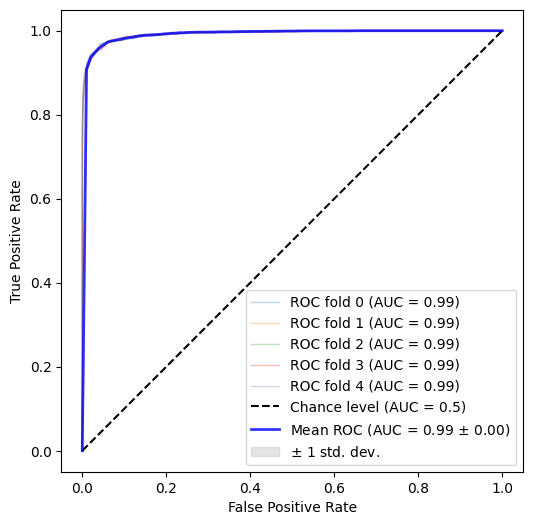

In [23]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))


for fold, (train, test) in tqdm([*enumerate(cv.split(X, y))]):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

In [24]:
aucs

[0.9930616257454692,
 0.9933295525996183,
 0.993228891121216,
 0.9927296013456716,
 0.993396535221478]

In [25]:
mean(aucs)

0.9931492412066906

### using the advertion package

In [26]:
advertion.validate(
    trainset=trainset,
    testset=testset,
    target="price_doc",
)

INFO: Working only with available numerical features, categorical features are not yet supported.
INFO: Will try to identify adversarial features (see: https://advertion.readthedocs.io/en/0.1.0-alpha/adversarial-features)
INFO: Identified adversarial feature: [name: id, statistic: 1.0, p-value: 0.0].
INFO: Identified adversarial feature: [name: max_floor, statistic: 0.3142988415214466, p-value: 0.0].
INFO: Identified adversarial feature: [name: material, statistic: 0.3141347510747924, p-value: 0.0].
INFO: Identified adversarial feature: [name: build_year, statistic: 0.3096463183976076, p-value: 0.0].
INFO: Identified adversarial feature: [name: num_room, statistic: 0.3142667815633885, p-value: 0.0].
INFO: Identified adversarial feature: [name: kitch_sq, statistic: 0.3144682388870098, p-value: 0.0].
INFO: Identified adversarial feature: [name: state, statistic: 0.3544364184470351, p-value: 0.0].
INFO: training and test datasets do not follow the same underlying distribution [mean ROC AU

{'adversarial_features': ['id',
  'max_floor',
  'material',
  'build_year',
  'num_room',
  'kitch_sq',
  'state'],
 'datasets_follow_same_distribution': False,
 'mean_roc_auc': 0.9870733237580953}

In [27]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)
classifier = xgb.XGBClassifier()

In [28]:
combined_dataset_shuffled.head()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
36438,36441,53.5,27.8,1.0,4.0,1.0,2000.0,2.0,7.6,2.0,...,0,0,0,0,0,0,0,0,0,3
27762,27765,57.0,NaN,20.0,1.0,1.0,NaN,2.0,1.0,NaN,...,0,0,0,0,0,0,0,0,0,0
32112,32115,34.1,16.7,8.0,9.0,2.0,1970.0,1.0,7.4,2.0,...,0,1,0,0,0,0,0,0,0,2
37146,37149,46.1,28.5,3.0,9.0,5.0,1971.0,2.0,6.0,4.0,...,1,1,0,0,0,0,0,0,0,2
13355,13358,39.0,NaN,3.0,17.0,1.0,NaN,1.0,1.0,NaN,...,0,0,0,0,0,0,0,0,0,4


In [29]:
X = combined_dataset_shuffled.drop(["_adval_label_"], axis=1)

In [30]:
X = X.drop(["id", "timestamp"], axis=1)

In [31]:
y = combined_dataset_shuffled["_adval_label_"]

In [32]:
predictions = []

for fold, (train, test) in tqdm([*enumerate(cv.split(X, y))]):
    classifier.fit(X.iloc[train], y.iloc[train])

    y_pred = classifier.predict_proba(X.iloc[test])[:, 1]

    predictions.extend(y_pred.tolist())

  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
combined_dataset_shuffled["preds"] = predictions

In [34]:
trainset = combined_dataset_shuffled[combined_dataset_shuffled["_adval_label_"] == 0.0]

trainset.shape

(30471, 293)

In [35]:
i = trainset["preds"].argsort()

sorted_train = trainset.iloc[i]

In [36]:
sorted_train

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology,preds
5592,5595,37.0,19.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,2,4.897290e-07
2546,2549,38.0,18.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,2,5.077677e-07
1340,1343,38.0,19.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,5.474540e-07
5072,5075,34.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,4,5.633994e-07
5866,5869,38.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,5.665751e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23837,23840,102.0,NaN,12.0,25.0,1.0,NaN,3.0,1.0,NaN,...,0,0,0,0,0,0,0,0,4,9.991301e-01
9375,9378,35.0,20.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,2,9.991896e-01
14583,14586,31.0,21.0,1.0,9.0,5.0,1964.0,1.0,5.0,2.0,...,1,0,0,0,0,0,0,0,1,9.994344e-01
15790,15793,66.0,48.0,5.0,5.0,2.0,1935.0,3.0,6.0,3.0,...,0,0,0,0,1,0,0,0,2,9.998305e-01


In [37]:
trainset[trainset["preds"] >= 0.5][["full_sq", "life_sq", "max_floor", "preds"]]

,full_sq,life_sq,max_floor,preds
30359,81.0,81.0,22.0,0.853813
29068,50.0,50.0,4.0,0.608003
28132,90.0,1.0,1.0,0.556087
29003,85.0,49.0,25.0,0.506222
30080,69.0,NaN,15.0,0.618344
...,...,...,...,...
28891,64.0,64.0,17.0,0.540079
21634,115.0,62.0,23.0,0.514691
19519,66.0,66.0,16.0,0.628838
30201,64.0,NaN,1.0,0.714351
